In [0]:
!pip install kaggle-cli
!kg download -u artesby -p 11211211203a -c sberbank-russian-housing-market
!unzip train.csv.zip

In [0]:
import pandas as pd
import numpy as np
np.warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [0]:
train = pd.read_csv("train.csv", index_col='id')

В начале без категориальных

In [0]:
y = np.log(1+train["price_doc"])
X_train = train.drop(["price_doc"], axis=1)
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        X_train.drop(c, axis=1, inplace=True)

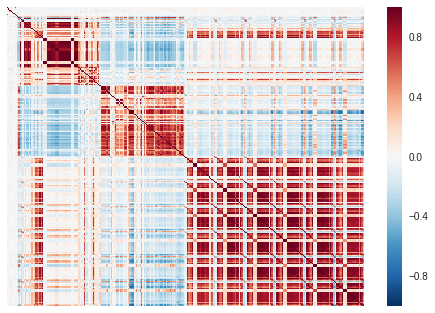

In [121]:
sns.heatmap(X_train.corr(), xticklabels=False, yticklabels=False)

Страх

Начальные параметры с потолка

In [0]:
xgb_params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}
dtrain = xgb.DMatrix(X_train, y)

[0]	train-rmse:13.6118	test-rmse:13.6118
[50]	train-rmse:0.441879	test-rmse:0.474159
[100]	train-rmse:0.408064	test-rmse:0.46517
[150]	train-rmse:0.387098	test-rmse:0.465601


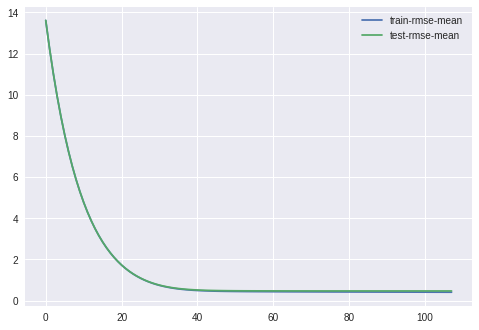

In [123]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

Теперь добавим другие признаки

In [0]:
obj_cols = []
X_train = train.drop(["timestamp", "price_doc"], axis=1)

#фикс выбросов подсмотрел в кернелах
X_train.loc[X_train.index == 10092, 'build_year'] = 2005
X_train.loc[X_train.index == 10093, 'build_year'] = 2009
X_train.loc[X_train.index == 15223, 'build_year'] = 1965
X_train.loc[X_train.index == 10092, 'state'] = 3.0
X_train.loc[X_train.index == 10093, 'state'] = 3.0
X_train.loc[X_train['build_year'] < 1800, 'build_year'] = X_train['build_year'].mean()


X_train['year'] = train['timestamp'].map(lambda x: int(x.split('-')[0])).astype(object)
X_train['month'] = train['timestamp'].map(lambda x: int(x.split('-')[1])).astype(object)
cols = X_train.columns
for c in cols:
    if X_train[c].dtype == 'object':
        obj_cols.append(c)
        X_train = pd.concat([
            X_train.drop(c, axis=1),
            pd.get_dummies(X_train[c], prefix=c)
        ], axis=1)

In [125]:
X_train.shape

(30471, 468)

In [0]:
X_train_, X_valid, y_train, y_valid = train_test_split(X_train.values, y.values, test_size=.25, random_state=17)

[0]	train-rmse:13.6156	test-rmse:13.6155
[50]	train-rmse:0.433201	test-rmse:0.476588
[100]	train-rmse:0.39137	test-rmse:0.467692


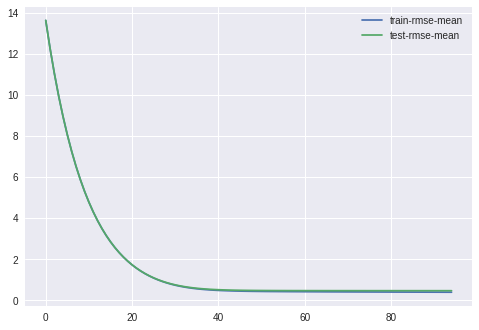

In [127]:
dtrain = xgb.DMatrix(X_train_, y_train, feature_names=X_train.columns)
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [0]:
n_trees = len(cv_output)

In [0]:
def print_gs_report(gs):
    plt.plot(range(gs.cv_results_['mean_train_score'].shape[0]), gs.cv_results_['mean_train_score']*-1, label='train')
    plt.plot(range(gs.cv_results_['mean_test_score'].shape[0]), gs.cv_results_['mean_test_score']*-1, label='test')
    plt.legend()
    plt.show()
    for i, p in enumerate(gs.cv_results_['params']):
        print(f"{i}: {p}")
    print("best:", gs.best_params_)

In [0]:
def update_params(gs, params):
    for p in gs.param_grid:
        params[p] = gs.best_params_[p]

In [131]:
%%time
grid = {
    'max_depth' : range(3, 7),
    'min_child_weight' : range(1, 6, 2)
}
reg = xgb.XGBRegressor(n_estimators=n_trees, **xgb_params)
gs = GridSearchCV(estimator=reg, param_grid=grid, scoring='neg_mean_squared_error',
                  n_jobs=-1, cv=3)
gs.fit(X_train_, y_train)

CPU times: user 37.3 s, sys: 237 ms, total: 37.5 s
Wall time: 11min 46s


In [0]:
# xgb_params['max_depth'] = gs.best_params_['max_depth']
# xgb_params['min_child_weight'] = gs.best_params_['min_child_weight']
update_params(gs, xgb_params)

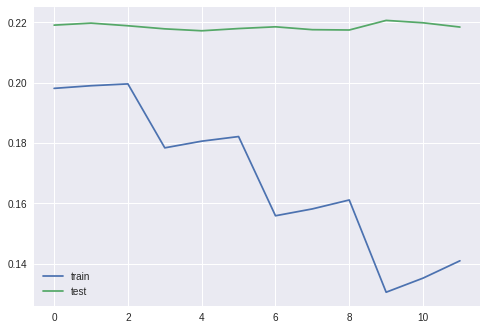

0: {'max_depth': 3, 'min_child_weight': 1}
1: {'max_depth': 3, 'min_child_weight': 3}
2: {'max_depth': 3, 'min_child_weight': 5}
3: {'max_depth': 4, 'min_child_weight': 1}
4: {'max_depth': 4, 'min_child_weight': 3}
5: {'max_depth': 4, 'min_child_weight': 5}
6: {'max_depth': 5, 'min_child_weight': 1}
7: {'max_depth': 5, 'min_child_weight': 3}
8: {'max_depth': 5, 'min_child_weight': 5}
9: {'max_depth': 6, 'min_child_weight': 1}
10: {'max_depth': 6, 'min_child_weight': 3}
11: {'max_depth': 6, 'min_child_weight': 5}
best: {'max_depth': 4, 'min_child_weight': 3}


In [133]:
print_gs_report(gs)

In [134]:
%%time
grid = {
    'gamma' : [0, 0.01, 0.1]
}
reg = xgb.XGBRegressor(n_estimators=n_trees, **xgb_params)
gs2 = GridSearchCV(estimator=reg, param_grid=grid, scoring='neg_mean_squared_error',
                  n_jobs=-1, cv=3)
gs2.fit(X_train_, y_train)

CPU times: user 37.1 s, sys: 136 ms, total: 37.2 s
Wall time: 3min 15s


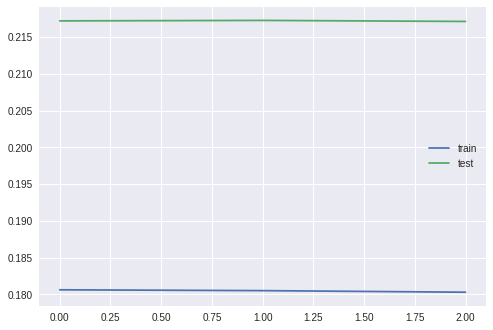

0: {'gamma': 0}
1: {'gamma': 0.01}
2: {'gamma': 0.1}
best: {'gamma': 0.1}


In [135]:
update_params(gs2, xgb_params)
print_gs_report(gs2)

In [136]:
%%time
grid = {
    'subsample' : [i / 10 for i in range(6, 11)],
    'colsample_bytree' : [i/ 10 for i in range(6, 11)]
}
reg = xgb.XGBRegressor(n_estimators=n_trees, **xgb_params)
gs3 = GridSearchCV(estimator=reg, param_grid=grid, scoring='neg_mean_squared_error',
                  n_jobs=-1, cv=3)
gs3.fit(X_train_, y_train)

CPU times: user 40.8 s, sys: 163 ms, total: 41 s
Wall time: 21min 40s


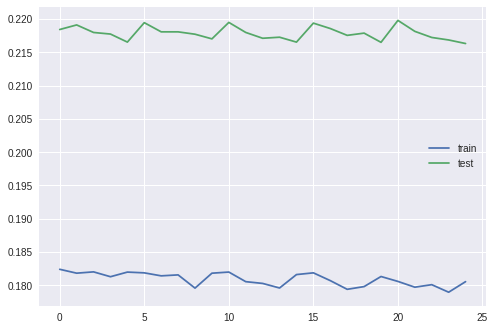

0: {'colsample_bytree': 0.6, 'subsample': 0.6}
1: {'colsample_bytree': 0.6, 'subsample': 0.7}
2: {'colsample_bytree': 0.6, 'subsample': 0.8}
3: {'colsample_bytree': 0.6, 'subsample': 0.9}
4: {'colsample_bytree': 0.6, 'subsample': 1.0}
5: {'colsample_bytree': 0.7, 'subsample': 0.6}
6: {'colsample_bytree': 0.7, 'subsample': 0.7}
7: {'colsample_bytree': 0.7, 'subsample': 0.8}
8: {'colsample_bytree': 0.7, 'subsample': 0.9}
9: {'colsample_bytree': 0.7, 'subsample': 1.0}
10: {'colsample_bytree': 0.8, 'subsample': 0.6}
11: {'colsample_bytree': 0.8, 'subsample': 0.7}
12: {'colsample_bytree': 0.8, 'subsample': 0.8}
13: {'colsample_bytree': 0.8, 'subsample': 0.9}
14: {'colsample_bytree': 0.8, 'subsample': 1.0}
15: {'colsample_bytree': 0.9, 'subsample': 0.6}
16: {'colsample_bytree': 0.9, 'subsample': 0.7}
17: {'colsample_bytree': 0.9, 'subsample': 0.8}
18: {'colsample_bytree': 0.9, 'subsample': 0.9}
19: {'colsample_bytree': 0.9, 'subsample': 1.0}
20: {'colsample_bytree': 1.0, 'subsample': 0.6}
21

In [137]:
update_params(gs3, xgb_params)
print_gs_report(gs3)

In [138]:
%%time
grid = {
    'reg_alpha' : [0, 0.01, 0.1, 1, 10],
    'reg_lambda' : [0, 0.01, 0.1, 1, 10]
}
reg = xgb.XGBRegressor(n_estimators=n_trees, **xgb_params)
gs4 = GridSearchCV(estimator=reg, param_grid=grid, scoring='neg_mean_squared_error',
                  n_jobs=-1, cv=3)
gs4.fit(X_train_, y_train)

CPU times: user 43.8 s, sys: 167 ms, total: 44 s
Wall time: 24min 15s


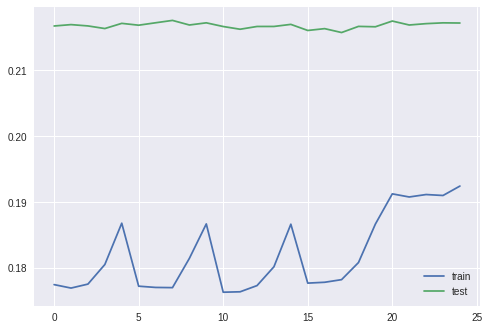

0: {'reg_alpha': 0, 'reg_lambda': 0}
1: {'reg_alpha': 0, 'reg_lambda': 0.01}
2: {'reg_alpha': 0, 'reg_lambda': 0.1}
3: {'reg_alpha': 0, 'reg_lambda': 1}
4: {'reg_alpha': 0, 'reg_lambda': 10}
5: {'reg_alpha': 0.01, 'reg_lambda': 0}
6: {'reg_alpha': 0.01, 'reg_lambda': 0.01}
7: {'reg_alpha': 0.01, 'reg_lambda': 0.1}
8: {'reg_alpha': 0.01, 'reg_lambda': 1}
9: {'reg_alpha': 0.01, 'reg_lambda': 10}
10: {'reg_alpha': 0.1, 'reg_lambda': 0}
11: {'reg_alpha': 0.1, 'reg_lambda': 0.01}
12: {'reg_alpha': 0.1, 'reg_lambda': 0.1}
13: {'reg_alpha': 0.1, 'reg_lambda': 1}
14: {'reg_alpha': 0.1, 'reg_lambda': 10}
15: {'reg_alpha': 1, 'reg_lambda': 0}
16: {'reg_alpha': 1, 'reg_lambda': 0.01}
17: {'reg_alpha': 1, 'reg_lambda': 0.1}
18: {'reg_alpha': 1, 'reg_lambda': 1}
19: {'reg_alpha': 1, 'reg_lambda': 10}
20: {'reg_alpha': 10, 'reg_lambda': 0}
21: {'reg_alpha': 10, 'reg_lambda': 0.01}
22: {'reg_alpha': 10, 'reg_lambda': 0.1}
23: {'reg_alpha': 10, 'reg_lambda': 1}
24: {'reg_alpha': 10, 'reg_lambda': 10}


In [139]:
update_params(gs4, xgb_params)
print_gs_report(gs4)

[0]	train-rmse:14.9747	test-rmse:14.9747
[50]	train-rmse:9.06901	test-rmse:9.0689
[100]	train-rmse:5.50102	test-rmse:5.50104
[150]	train-rmse:3.35036	test-rmse:3.35089
[200]	train-rmse:2.06177	test-rmse:2.06357
[250]	train-rmse:1.30137	test-rmse:1.30545
[300]	train-rmse:0.868361	test-rmse:0.876016
[350]	train-rmse:0.638209	test-rmse:0.650594
[400]	train-rmse:0.527187	test-rmse:0.544236
[450]	train-rmse:0.477915	test-rmse:0.498741
[500]	train-rmse:0.456494	test-rmse:0.480425
[550]	train-rmse:0.446339	test-rmse:0.472961
[600]	train-rmse:0.440697	test-rmse:0.469786
[650]	train-rmse:0.436898	test-rmse:0.468166
[700]	train-rmse:0.433962	test-rmse:0.467235
[750]	train-rmse:0.431351	test-rmse:0.466584
[800]	train-rmse:0.42889	test-rmse:0.46606
[850]	train-rmse:0.426701	test-rmse:0.465691
[900]	train-rmse:0.42462	test-rmse:0.465455
[950]	train-rmse:0.422629	test-rmse:0.465248
[1000]	train-rmse:0.420639	test-rmse:0.465049
[1050]	train-rmse:0.418617	test-rmse:0.464883
[1100]	train-rmse:0.416664	

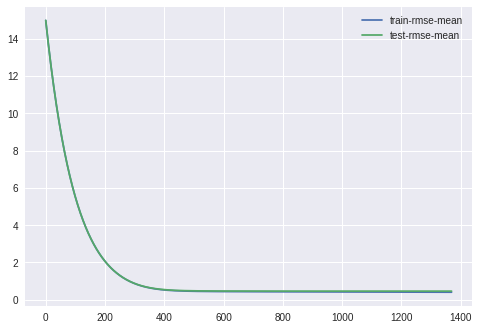

In [140]:
xgb_params['learning_rate'] = 0.01

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [0]:
n_trees = len(cv_output)

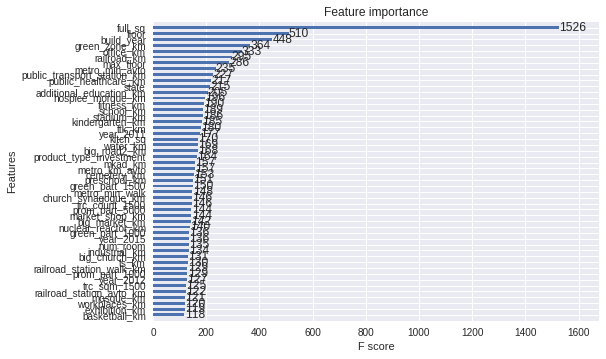

In [142]:
reg = xgb.train(xgb_params, dtrain, num_boost_round=n_trees)

xgb.plot_importance(reg, max_num_features=50, height=0.5)

Тут еше надо было посмотреть на отложенной выборке качество, но у меня закончилось время аренды машины на колабе, и надо все заново считать :<

In [0]:
dvalid = xgb.DMatrix(X_valid)
np.sqrt(metrics.mean_squared_error(y_valid, reg.predict(X_valid)))